In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def generate_true_recursive_sine(length=1000):
    omega = 0.15
    coeff = 2 * np.cos(omega) # The recursive coefficient
    seq = [0.5, 0.55]
    for _ in range(length - 2):
        # Rule: xt+1 = coeff*(xt - 0.5) - (xt-1 - 0.5) + 0.5
        next_val = coeff * (seq[-1] - 0.5) - (seq[-2] - 0.5) + 0.5
        next_val = np.clip(next_val, 0.2501, 0.7499)
        seq.append(next_val)
    return np.array(seq, dtype=np.float32)

full_data = generate_true_recursive_sine(1000)

# Window size here determines the "unrolling" steps for the RNN gradients,
# but at each step, the input will be a single scalar.
SEQUENCE_LENGTH = 15

def create_dataset_scalar_rnn(data, k):
    X, y = [], []
    for i in range(len(data) - k):
        # Shape: [sequence_length, input_size=1]
        X.append(data[i : i + k].reshape(-1, 1))
        y.append(data[i + k])
    return torch.tensor(np.array(X)), torch.tensor(np.array(y)).view(-1, 1)

X_train, y_train = create_dataset_scalar_rnn(full_data[:600], SEQUENCE_LENGTH)
print(f"RNN Input Shape: {X_train.shape}") # [Batch, Seq_Len, 1]

RNN Input Shape: torch.Size([585, 15, 1])


In [2]:
class ScalarMemoryRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32):
        super().__init__()
        # Scalar input (size=1)
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        # Prediction from hidden state
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: [batch, seq_len, 1]
        # out: [batch, seq_len, hidden_size]
        out, _ = self.rnn(x)
        # Predict xt+1 using the final hidden state ht
        return self.fc(out[:, -1, :])

model = ScalarMemoryRNN(input_size=1, hidden_size=32)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [3]:
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.10f}")

Epoch 0, Loss: 0.2470602989
Epoch 200, Loss: 0.0000590437
Epoch 400, Loss: 0.0000202874
Epoch 600, Loss: 0.0000098318
Epoch 800, Loss: 0.0000052348


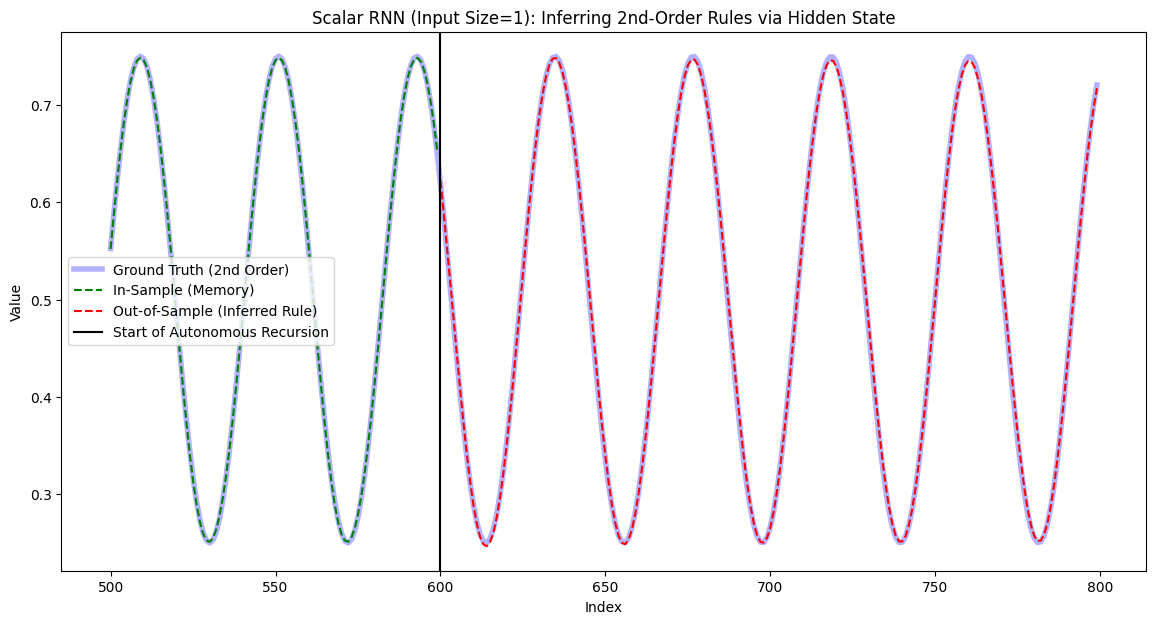

In [4]:
# --- 1. In-Sample Prediction (Indices 500-600) ---
train_preds = []
model.eval()
with torch.no_grad():
    for i in range(500 - SEQUENCE_LENGTH, 600 - SEQUENCE_LENGTH):
        input_seq = X_train[i].unsqueeze(0)
        train_preds.append(model(input_seq).item())

# --- 2. Out-of-Sample Recursion (Indices 600-800) ---
# Seed with the last training sequence
current_seq = full_data[600-SEQUENCE_LENGTH:600].reshape(1, SEQUENCE_LENGTH, 1)
future_preds = []
with torch.no_grad():
    for _ in range(200):
        input_tensor = torch.tensor(current_seq, dtype=torch.float32)
        next_val = model(input_tensor).item()
        future_preds.append(next_val)

        # Shift the sequence: discard oldest scalar, append newest prediction
        new_val_tensor = np.array([[[next_val]]], dtype=np.float32)
        current_seq = np.concatenate((current_seq[:, 1:, :], new_val_tensor), axis=1)

# --- 3. Plotting ---
plt.figure(figsize=(14, 7))
plt.plot(np.arange(500, 800), full_data[500:800], label='Ground Truth (2nd Order)', color='blue', alpha=0.3, lw=4)
plt.plot(np.arange(500, 600), train_preds, label='In-Sample (Memory)', color='green', ls='--')
plt.plot(np.arange(600, 800), future_preds, label='Out-of-Sample (Inferred Rule)', color='red', ls='--')
plt.axvline(x=600, color='black', label='Start of Autonomous Recursion')
plt.title("Scalar RNN (Input Size=1): Inferring 2nd-Order Rules via Hidden State")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()

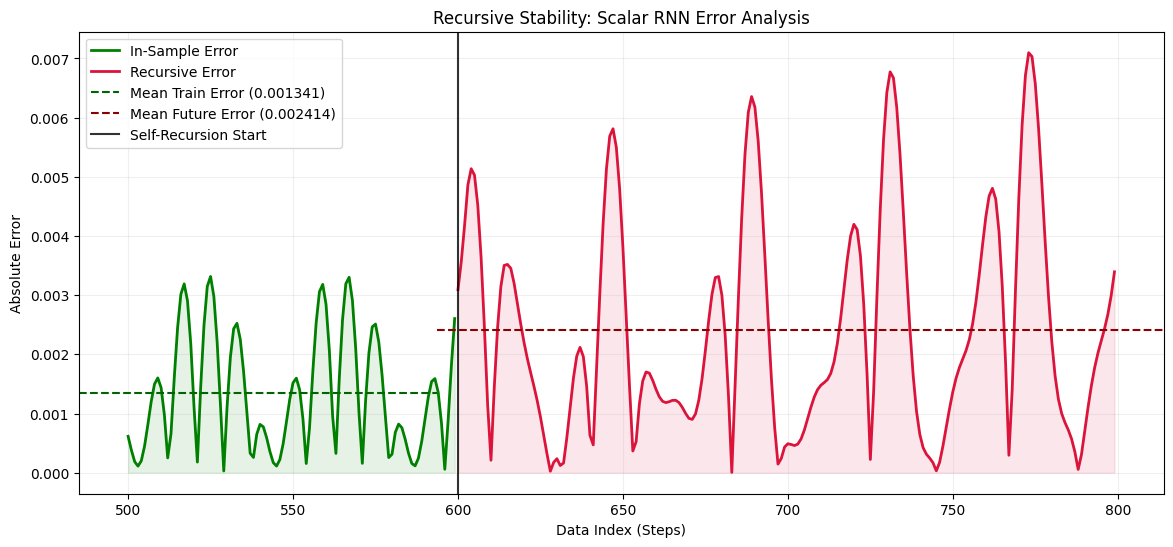

Stability Ratio (Future/Train): 1.80x


In [9]:
# --- STEP 1: CALCULATE ERRORS AND MEANS ---
error_train = np.abs(np.array(train_preds) - full_data[500:600])
error_future = np.abs(np.array(future_preds) - full_data[600:800])

mean_train_error = np.mean(error_train)
mean_future_error = np.mean(error_future)

indices = np.arange(500, 800)
total_error = np.concatenate((error_train, error_future))

# --- STEP 2: PLOTTING ---
plt.figure(figsize=(14, 6))

# Plot the absolute error curves
plt.plot(indices[:100], error_train, color='green', lw=2, label='In-Sample Error')
plt.plot(indices[100:], error_future, color='crimson', lw=2, label='Recursive Error')

# Add the Mean Lines
plt.axhline(y=mean_train_error, xmin=0, xmax=0.33, color='darkgreen', linestyle='--',
            label=f'Mean Train Error ({mean_train_error:.6f})')

plt.axhline(y=mean_future_error, xmin=0.33, xmax=1.0, color='darkred', linestyle='--',
            label=f'Mean Future Error ({mean_future_error:.6f})')

# Fill areas for visual clarity
plt.fill_between(indices[:100], error_train, color='green', alpha=0.1)
plt.fill_between(indices[100:], error_future, color='crimson', alpha=0.1)

# Transition marker
plt.axvline(x=600, color='black', linestyle='-', alpha=0.8, label='Self-Recursion Start')

plt.title("Recursive Stability: Scalar RNN Error Analysis")
plt.xlabel("Data Index (Steps)")
plt.ylabel("Absolute Error")
plt.grid(True, alpha=0.2)
plt.legend(loc='upper left')

plt.show()

print(f"Stability Ratio (Future/Train): {mean_future_error / mean_train_error:.2f}x")